# Property Listed Price and Rent Prediction💸

## *Loading Dataset*

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import time

In [2]:
# Load dataset
data = pd.read_csv('./data/Cleaned_data.csv')

## *Feature Engineering*

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21745 entries, 0 to 21744
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           21745 non-null  object 
 1   City            21745 non-null  object 
 2   Street          21745 non-null  object 
 3   Zipcode         21745 non-null  int64  
 4   Bedroom         21745 non-null  float64
 5   Bathroom        21745 non-null  float64
 6   Area            21745 non-null  float64
 7   PPSq            21745 non-null  float64
 8   LotArea         21745 non-null  float64
 9   MarketEstimate  21745 non-null  float64
 10  RentEstimate    21745 non-null  float64
 11  Latitude        21745 non-null  float64
 12  Longitude       21745 non-null  float64
 13  ListedPrice     21745 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 2.3+ MB


In [3]:
df = data.copy()
df.sort_values(by='Zipcode')

,State,City,Street,Zipcode,Bedroom,Bathroom,Area,PPSq,LotArea,MarketEstimate,RentEstimate,Latitude,Longitude,ListedPrice
9237,MA,Amherst,Sunderland Rd,1002,4.0,3.0,3120.0,181.089744,2.700000,526800.000000,3499.0,42.422096,-72.538150,565000.0
8926,MA,Belchertown,Gold St,1007,3.0,2.0,1296.0,270.061728,1.730000,355000.000000,2949.0,42.342020,-72.410630,350000.0
8804,MA,Belchertown,Mill Valley Rd,1007,3.0,2.0,1512.0,210.978836,1.760000,324600.000000,2274.0,42.263100,-72.374750,319000.0
8812,MA,Chester,Maple St,1011,5.0,2.0,2136.0,46.816479,0.450000,88900.000000,2800.0,42.278910,-72.979530,100000.0
8915,MA,Chicopee,Fairmont St,1013,2.0,1.0,1008.0,237.996032,0.511387,242000.000000,1800.0,42.185658,-72.598274,239900.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,AK,Ketchikan,Schoenbar Rd,99901,4.0,3.0,2112.0,233.428030,0.340000,475400.000000,1949.0,55.347317,-131.637570,493000.0
516,AK,Coffman Cove,Coho Dr,99918,3.0,3.0,1850.0,539.459459,0.400000,942680.641922,2585.0,56.021515,-132.827740,998000.0
685,AK,Coffman Cove,NE Minke,99918,1.0,1.0,1200.0,290.833333,3.900000,346900.000000,1900.0,56.012170,-132.810640,349000.0
751,AK,Wrangell,.2 Mile Zimovia Hwy,99929,3.0,2.0,1800.0,206.666667,0.980000,370600.000000,2500.0,56.363064,-132.356580,372000.0


In [6]:
# Function to preprocess the data
def preprocess_data(df):
    features = df[['Zipcode','Bedroom', 'Bathroom', 'Area', 'PPSq']]
    features_for_listed_price = features.copy()
    features_for_rent_estimate = features.copy()

    return features_for_listed_price, features_for_rent_estimate, df['ListedPrice'], df['RentEstimate']

features_for_listed_price, features_for_rent_estimate, y_listed, y_rent = preprocess_data(df)

## *ML Model Training*

In [7]:
# Split dataset for ListedPrice and RentEstimate
X_train_listed, X_test_listed, y_train_listed, y_test_listed = train_test_split(features_for_listed_price, y_listed, test_size=0.2, random_state=42)
X_train_rent, X_test_rent, y_train_rent, y_test_rent = train_test_split(features_for_rent_estimate, y_rent, test_size=0.2, random_state=42)

# Desfine scalers for each model
scaler_listed = MinMaxScaler()
scaler_rent = MinMaxScaler()

X_train_listed_scaled = scaler_listed.fit_transform(X_train_listed)
X_test_listed_scaled = scaler_listed.transform(X_test_listed)

X_train_rent_scaled = scaler_rent.fit_transform(X_train_rent)
X_test_rent_scaled = scaler_rent.transform(X_test_rent)

In [13]:
# Define models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': XGBRegressor(),
    'CatBoostRegressor': CatBoostRegressor(random_state=42, verbose=0),
    'LightGBM': lgb.LGBMRegressor(random_state=42),
}

# Function to evaluate model's performance
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    start_time = time.time()
    cv_rmse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mae_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    
    cv_rmse = [math.sqrt(-score) for score in cv_rmse_scores]
    cv_rmse_mean = np.mean(cv_rmse)
    cv_r2_mean = np.mean(cv_r2_scores)
    cv_mae_mean = -np.mean(cv_mae_scores)
    
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    start_time = time.time()
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    return [name, cv_rmse_mean, cv_r2_mean, cv_mae_mean, test_rmse, test_r2, test_mae, train_time, prediction_time]

In [14]:
def run_evaluation(X_train, y_train, X_test, y_test):
    results = []
    for name, model in models.items():
        result = evaluate_model(model, name, X_train, y_train, X_test, y_test)
        results.append(result)
    return pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 'Test RMSE', 'Test R-squared', 'Test MAE', 'Train Time', 'Prediction Time'])

print("Evaluating models for ListedPrice...")
results_listed = run_evaluation(X_train_listed_scaled, y_train_listed, X_test_listed_scaled, y_test_listed)

print("\nEvaluating models for RentEstimate...")
results_rent = run_evaluation(X_train_rent_scaled, y_train_rent, X_test_rent_scaled, y_test_rent)

Evaluating models for ListedPrice...
Evaluating LinearRegression...
Evaluating RandomForestRegressor...
Evaluating GradientBoostingRegressor...
Evaluating XGBRegressor...
Evaluating CatBoostRegressor...
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 13916, number of used features: 5
[LightGBM] [Info] Start training from score 546054.813596
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 13917, number of used features: 5
[LightGBM] [Info] Start training from score 526935.680032
[LightGBM] [Info] Au

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 13917, number of used features: 5
[LightGBM] [Info] Start training from score 2721.319597
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803
[LightGBM] [Info] Number of data points in the train set: 13917, number of used features: 5
[LightGBM] [Info] Start training from score 2704.601535
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 804
[LightGBM] [Info] Number of data points in the train set: 13917, number of used features: 5
[LightGBM] [Info] Start tra

In [15]:
# Function to display and sort the results
def display_results(results, target_name):
    results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 'Test RMSE', 'Test R-squared', 'Test MAE', 'Train Time', 'Prediction Time'])
    results_df_sorted = results_df.sort_values(by='Test R-squared')
    return results_df_sorted

results_listed_df = display_results(results_listed, 'ListedPrice')
results_rent_df = display_results(results_rent, 'RentEstimate')

In [16]:
results_listed_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Train Time,Prediction Time
0,LinearRegression,883400.157822,0.648933,324536.239499,623777.163061,0.736367,307238.718093,0.261281,0.000000
3,XGBRegressor,692336.277517,0.790386,46759.986525,499782.678075,0.830760,36779.849397,5.353165,0.006004
4,CatBoostRegressor,733609.164531,0.751647,49463.854548,407844.146502,0.887299,36811.148490,91.286867,0.006669
5,LightGBM,649303.441984,0.815466,47250.429961,394660.429251,0.894467,32534.204963,4.387874,0.009510
1,RandomForestRegressor,446619.178836,0.911052,23287.406538,274650.682508,0.948890,15480.699193,161.469541,0.146511
2,GradientBoostingRegressor,450070.360470,0.912065,46535.998711,192951.360403,0.974775,34897.823126,40.700797,0.006999


In [17]:
results_rent_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Train Time,Prediction Time
2,GradientBoostingRegressor,2162.826795,0.671866,486.839652,2008.726397,0.668315,480.406770,37.977802,0.005996
1,RandomForestRegressor,2050.259320,0.701766,487.456921,1975.217791,0.679288,475.836008,167.303798,0.211630
0,LinearRegression,2567.147773,0.557912,872.376599,1972.398213,0.680203,831.152850,0.085004,0.000000
3,XGBRegressor,2238.458088,0.655930,492.628328,1755.733601,0.746603,463.567851,3.633009,0.004011
5,LightGBM,2128.983149,0.670490,484.738668,1747.417057,0.748998,459.419273,3.916708,0.013013
4,CatBoostRegressor,2157.439193,0.678907,479.154742,1664.783464,0.772176,450.707120,89.832342,0.005003


## *Hyperparameter Tuning*

In [18]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# Define hyperparameter grids
param_grids = {
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'LightGBM': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'num_leaves': [31, 62, 127]
    },
    'CatBoostRegressor': {
        'iterations': [500, 1000],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.1, 0.2]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5]
    },
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
}

# Function to perform hyperparameter tuning
def hyperparameter_tuning(model_name, model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {-grid_search.best_score_}")
    return grid_search.best_estimator_

# Function to evaluate model performance
def evaluate_model(model, name, X_train, y_train, X_test, y_test):
    print(f"Evaluating {name}...")
    
    start_time = time.time()
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    cv_rmse_scores = [math.sqrt(-score) for score in scores]
    cv_r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    cv_mae_scores = -cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    train_time = time.time() - start_time
    
    # Training on the training set
    model.fit(X_train, y_train)
    
    start_time = time.time()
    # Predicting on the test set
    y_pred = model.predict(X_test)
    prediction_time = time.time() - start_time
    
    # Computing test set metrics
    test_rmse = math.sqrt(mean_squared_error(y_test, y_pred))
    test_r2 = r2_score(y_test, y_pred)
    test_mae = mean_absolute_error(y_test, y_pred)
    
    return [name, np.mean(cv_rmse_scores), np.mean(cv_r2_scores), np.mean(cv_mae_scores), test_rmse, test_r2, test_mae, train_time, prediction_time]

In [19]:
# Perform hyperparameter tuning and evaluation for ListedPrice models
tuned_models_listed = {}
results_listed = []

for model_name in ['GradientBoostingRegressor', 'LightGBM', 'CatBoostRegressor', 'XGBRegressor']:
    tuned_model = hyperparameter_tuning(model_name, models[model_name], param_grids[model_name], X_train_listed_scaled, y_train_listed)
    tuned_models_listed[model_name] = tuned_model
    result = evaluate_model(tuned_model, model_name, X_train_listed_scaled, y_train_listed, X_test_listed_scaled, y_test_listed)
    results_listed.append(result)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for GradientBoostingRegressor: {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
Best score for GradientBoostingRegressor: 27342.9952327523
Evaluating GradientBoostingRegressor...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 17396, number of used features: 5
[LightGBM] [Info] Start training from score 536621.625489
Best parameters for LightGBM: {'learning_rate': 0.1, 'n_estimators': 100, 'num_leaves': 127}
Best score for LightGBM: 44924.26957845647
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

In [20]:
# Perform hyperparameter tuning and evaluation for RentEstimate models
tuned_models_rent = {}
results_rent = []

for model_name in ['CatBoostRegressor', 'LightGBM', 'RandomForestRegressor', 'GradientBoostingRegressor']:
    tuned_model = hyperparameter_tuning(model_name, models[model_name], param_grids[model_name], X_train_rent_scaled, y_train_rent)
    tuned_models_rent[model_name] = tuned_model
    result = evaluate_model(tuned_model, model_name, X_train_rent_scaled, y_train_rent, X_test_rent_scaled, y_test_rent)
    results_rent.append(result)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for CatBoostRegressor: {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}
Best score for CatBoostRegressor: 480.6256860802033
Evaluating CatBoostRegressor...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 805
[LightGBM] [Info] Number of data points in the train set: 17396, number of used features: 5
[LightGBM] [Info] Start training from score 2711.286607
Best parameters for LightGBM: {'learning_rate': 0.01, 'n_estimators': 300, 'num_leaves': 127}
Best score for LightGBM: 479.36868095905703
Evaluating LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 803


In [21]:
# Function to display and sort the results
def display_results(results, target_name):
    results_df = pd.DataFrame(results, columns=['Model', 'CV RMSE', 'CV R-squared', 'CV MAE', 'Test RMSE', 'Test R-squared', 'Test MAE', 'Train Time', 'Prediction Time'])
    results_df_sorted = results_df.sort_values(by='Test MAE')
    print(f"\nResults for {target_name}:")
    print(results_df_sorted)
    return results_df_sorted

results_listed_df = display_results(results_listed, 'ListedPrice')
results_rent_df = display_results(results_rent, 'RentEstimate')


Results for ListedPrice:
                       Model        CV RMSE  CV R-squared        CV MAE  \
0  GradientBoostingRegressor  443599.022405      0.912283  27342.995233   
1                   LightGBM  656403.248698      0.811741  44924.269578   
3               XGBRegressor  706703.325853      0.777014  46030.940026   
2          CatBoostRegressor  738086.900121      0.744001  44164.409798   

       Test RMSE  Test R-squared      Test MAE  Train Time  Prediction Time  
0  234816.610951        0.962641  17918.707908  189.743842         0.026757  
1  391234.926843        0.896291  29291.304414   13.922729         0.021911  
3  463551.667888        0.854408  35277.856186    7.852570         0.011003  
2  470496.287582        0.850013  35748.709870  138.097621         0.008945  

Results for RentEstimate:
                       Model      CV RMSE  CV R-squared      CV MAE  \
0          CatBoostRegressor  2225.629904      0.659495  480.625686   
3  GradientBoostingRegressor  1943.1016

In [22]:
results_listed_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Train Time,Prediction Time
0,GradientBoostingRegressor,443599.022405,0.912283,27342.995233,234816.610951,0.962641,17918.707908,189.743842,0.026757
1,LightGBM,656403.248698,0.811741,44924.269578,391234.926843,0.896291,29291.304414,13.922729,0.021911
3,XGBRegressor,706703.325853,0.777014,46030.940026,463551.667888,0.854408,35277.856186,7.852570,0.011003
2,CatBoostRegressor,738086.900121,0.744001,44164.409798,470496.287582,0.850013,35748.709870,138.097621,0.008945


In [23]:
results_rent_df

,Model,CV RMSE,CV R-squared,CV MAE,Test RMSE,Test R-squared,Test MAE,Train Time,Prediction Time
0,CatBoostRegressor,2225.629904,0.659495,480.625686,1748.225794,0.748765,463.145192,84.150370,0.004977
3,GradientBoostingRegressor,1943.101614,0.731685,467.870427,1953.090122,0.686434,466.370811,116.992342,0.015985
1,LightGBM,2074.935061,0.698739,479.368681,1888.097620,0.706955,466.529441,42.394227,0.041184
2,RandomForestRegressor,1996.987895,0.712297,477.067129,2086.836562,0.642018,471.997501,359.089389,0.274713


## *Saving the model*

In [8]:
import joblib

# Best parameters from GridSearchCV
best_params_listed = {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300}
best_params_rent = {'depth': 6, 'iterations': 1000, 'learning_rate': 0.1}

# Train final GradientBoostingRegressor model for ListedPrice
final_model_listed = GradientBoostingRegressor(**best_params_listed)
final_model_listed.fit(X_train_listed_scaled, y_train_listed)

GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=300)

In [10]:
# Train final CatBoostRegressor model for RentEstimate
final_model_rent = CatBoostRegressor(**best_params_rent, verbose=0)
final_model_rent.fit(X_train_rent_scaled, y_train_rent)

In [41]:
# Save trained models and the scalar fitted
joblib.dump(final_model_listed, 'final_model_listed.pkl')
joblib.dump(final_model_rent, 'final_model_rent.pkl')

joblib.dump(scaler_listed, 'scaler_listed.pkl')
joblib.dump(scaler_rent, 'scaler_rent.pkl')
print("Models and scalers saved successfully!")

Models and scalers saved successfully!


## *Comparing Predictions*

In [28]:
# Gradient Boosting model - Best performing model for Listed Price prediction
y_pred_gbr = final_model_listed.predict(X_test_listed_scaled)
gbr_results = pd.DataFrame({'Actual Listed Price': y_test_listed, 'Predicted Listed Price': y_pred_gbr})
gbr_results['Actual Listed Price'] = gbr_results['Actual Listed Price'].round(2)
gbr_results['Predicted Listed Price'] = gbr_results['Predicted Listed Price'].round(2)
gbr_results.sample(n=5)

,Actual Listed Price,Predicted Listed Price
4874,530000.0,532822.81
1215,414999.0,404083.91
7752,384500.0,379543.79
18696,424999.0,422820.14
2545,399900.0,402782.27


In [40]:
# CatBoostRegressor model - Best performing model for Rent Price prediction
y_pred_cbr = final_model_rent.predict(X_test_rent_scaled)
cbr_results = pd.DataFrame({'Actual Rent Price': y_test_rent, 'Predicted Rent Price': y_pred_cbr})
cbr_results['Actual Rent Price'] = cbr_results['Actual Rent Price'].round(2)
cbr_results['Predicted Rent Price'] = cbr_results['Predicted Rent Price'].round(2)
cbr_results.sample(n=5)

,Actual Rent Price,Predicted Rent Price
16016,2394.0,2683.92
18347,1635.0,1625.87
10814,1949.0,2070.24
14979,1350.0,1384.27
5405,1250.0,1248.24


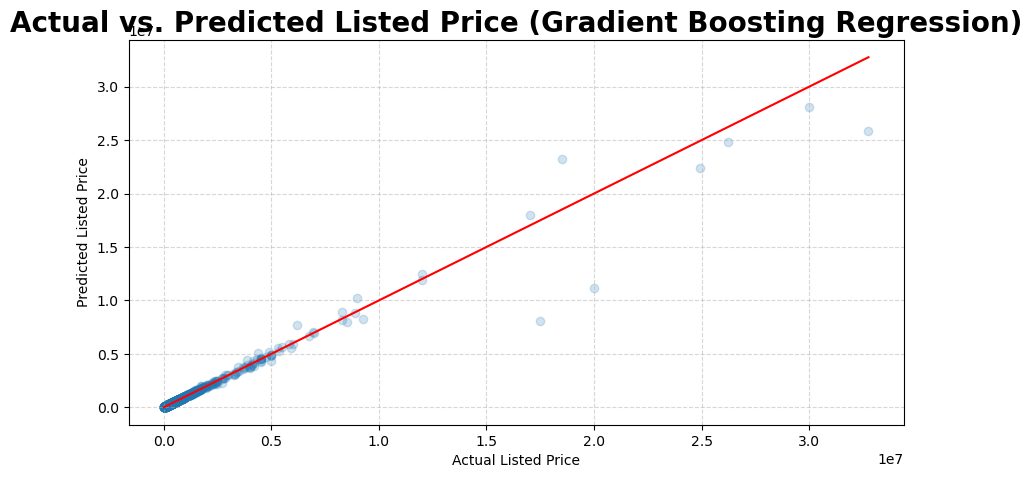

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatterplot - Actual vs. Predicted Listed price
plt.figure(figsize=(10,5))

plt.scatter(y_test_listed, y_pred_gbr, alpha=0.2)
plt.plot([min(y_test_listed), max(y_test_listed)], [min(y_test_listed), max(y_test_listed)], color='red')

plt.title('Actual vs. Predicted Listed Price (Gradient Boosting Regression)', size=20, weight='bold', y=0.999)
plt.xlabel('Actual Listed Price')
plt.ylabel('Predicted Listed Price')

plt.grid(linestyle = "dashed", alpha=0.5)
plt.show()

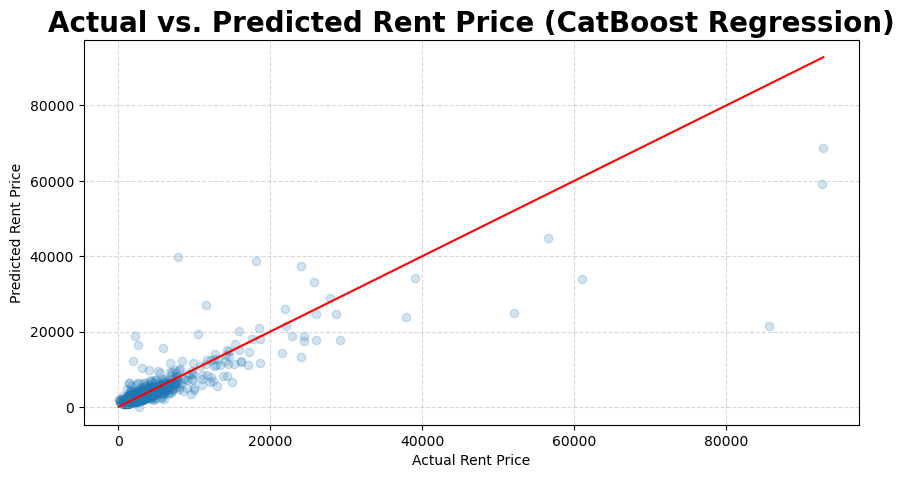

In [38]:
# Scatterplot - Actual vs. Predicted Rent price
plt.figure(figsize=(10,5))

plt.scatter(y_test_rent, y_pred_cbr, alpha=0.2)
plt.plot([min(y_test_rent), max(y_test_rent)], [min(y_test_rent), max(y_test_rent)], color='red')

plt.title('Actual vs. Predicted Rent Price (CatBoost Regression)', size=20, weight='bold', y=0.999)
plt.xlabel('Actual Rent Price')
plt.ylabel('Predicted Rent Price')

plt.grid(linestyle = "dashed", alpha=0.5)
plt.show()